# Part A: Exploratory Data Analysis (EDA)

## 1. Load dataset


In [1]:
# Step 1: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid")

# Step 2: Load dataset
df = pd.read_csv("ecommerce_sales_data.csv")

# Show first few rows
df.head()


,Order Date,Product Name,Category,Region,Quantity,Sales,Profit
0,2024-12-31,Printer,Office,North,4,3640,348.93
1,2022-11-27,Mouse,Accessories,East,7,1197,106.53
2,2022-05-11,Tablet,Electronics,South,5,5865,502.73
3,2024-03-16,Mouse,Accessories,South,2,786,202.87
4,2022-09-10,Mouse,Accessories,West,1,509,103.28


**Observation:**  
We can see the dataset columns and a few sample records. It contains both numeric and categorical features.


# Part C: Multiple Linear Regression

## 1. Select TWO or MORE features
We include `Quantity` and `Profit`, and also encode categorical columns.


In [13]:
# Convert Order Date to datetime and extract useful features
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Order_Year"] = df["Order Date"].dt.year
df["Order_Month"] = df["Order Date"].dt.month

# Drop original date column
df_ml = df.drop(columns=["Order Date"])

# One-hot encode categorical features
df_ml = pd.get_dummies(df_ml, columns=["Product Name", "Category", "Region"], drop_first=True)

# Features and target
X = df_ml.drop(columns=["Sales"])
y = df_ml["Sales"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
multi_reg = LinearRegression()
multi_reg.fit(X_train, y_train)

# Predict
y_pred = multi_reg.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)


MSE: 1754854.7635348828
RMSE: 1324.7093128437207
R2 Score: 0.7202933867924615


**Observation:**  
Using multiple features usually improves prediction accuracy compared to simple regression.


## 5. Interpret coefficients


In [14]:
coeff_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": multi_reg.coef_
}).sort_values(by="Coefficient", ascending=False)

coeff_df.head(10)


,Feature,Coefficient
0,Quantity,258.500915
10,Product Name_Smartphone,121.554101
17,Region_West,112.579825
14,Category_Office,58.389700
9,Product Name_Printer,58.389700
12,Product Name_Tablet,57.925417
15,Region_North,56.032601
2,Order_Year,34.319496
7,Product Name_Monitor,19.307197
8,Product Name_Mouse,16.190711


**Interpretation:**  
Positive coefficients increase Sales, negative coefficients decrease Sales.


**Part C Summary:**  
Multiple regression captures more complexity and usually improves model performance.


# Part D: Polynomial Regression

## 1. Apply PolynomialFeatures


In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Use Quantity for polynomial regression
X = df[["Quantity"]]
y = df["Sales"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Polynomial Regression model (degree 2)
poly_model = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("lin_reg", LinearRegression())
])

poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)

# Compare with simple linear regression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

# Evaluation
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

mse_lin = mean_squared_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mse_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print("Linear -> MSE:", mse_lin, "RMSE:", rmse_lin, "R2:", r2_lin)
print("Poly   -> MSE:", mse_poly, "RMSE:", rmse_poly, "R2:", r2_poly)


Linear -> MSE: 3373973.040398608 RMSE: 1836.8377828209566 R2: 0.46222183636299696
Poly   -> MSE: 3372895.4080471694 RMSE: 1836.544420384971 R2: 0.4623936003753626


**Observation:**  
Polynomial regression may improve performance if the relationship is non-linear.


## 4. Explain why polynomial performs better or worse
**Explanation:**  
If polynomial regression gives lower error and higher R², the relationship is non-linear.  
If not, a simple linear relationship is sufficient.


**Part D Summary:**  
Polynomial regression is useful for capturing non-linear patterns but can overfit.


# Part E: Regularization

## 1. Apply Ridge Regression  
## 2. Apply Lasso Regression


In [16]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

# Train-test split using the multi-feature dataset
X = df_ml.drop(columns=["Sales"])
y = df_ml["Sales"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

# Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

# Metrics
ridge_r2 = r2_score(y_test, y_pred_ridge)
lasso_r2 = r2_score(y_test, y_pred_lasso)

print("Ridge R2:", ridge_r2)
print("Lasso R2:", lasso_r2)


Ridge R2: 0.7202972177611139
Lasso R2: 0.7203183359950427


## 3. Compare coefficients


In [17]:
ridge_coef = pd.Series(ridge.coef_, index=X.columns)
lasso_coef = pd.Series(lasso.coef_, index=X.columns)

coef_compare = pd.DataFrame({
    "Ridge": ridge_coef,
    "Lasso": lasso_coef
})

coef_compare.head(10)


,Ridge,Lasso
Quantity,666.299862,666.108748
Profit,1655.984424,1656.586901
Order_Year,27.886091,27.794693
Order_Month,-3.401675,-3.312594
Product Name_Headphones,-20.143369,-21.800444
Product Name_Keyboard,-11.478773,-13.157084
Product Name_Laptop,-43.490454,-43.494488
Product Name_Monitor,5.237007,3.349989
Product Name_Mouse,4.254182,2.384193
Product Name_Printer,17.188186,31.251301


**Observation:**  
Lasso tends to shrink some coefficients to zero, acting as feature selection.


## 4. Explain feature selection and overfitting control
**Explanation:**  
- Ridge reduces large coefficients to control overfitting.  
- Lasso can drop irrelevant features by making coefficients exactly zero.


**Part E Summary:**  
Regularization improves stability and reduces overfitting, especially with many features.


# Part F: Model Diagnostics

## 1. Residual vs Predicted plot


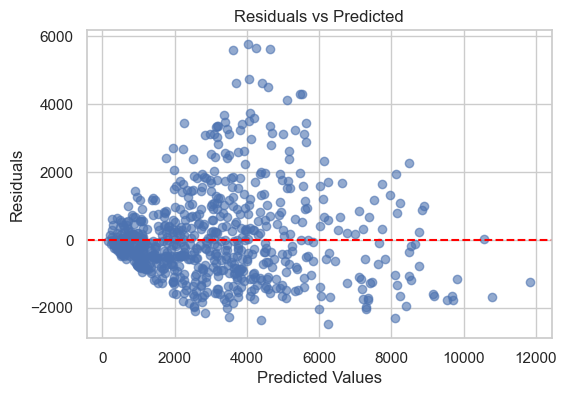

In [18]:
# Use multiple regression model predictions
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


**Observation:**  
Residuals should be randomly scattered around zero. Patterns indicate non-linearity or heteroscedasticity.


## 2. Validate regression assumptions

### Linearity  
Residual plot should show no curve.

### Homoscedasticity  
Residual spread should be roughly equal across predictions.

### Normality  
Plot histogram of residuals.


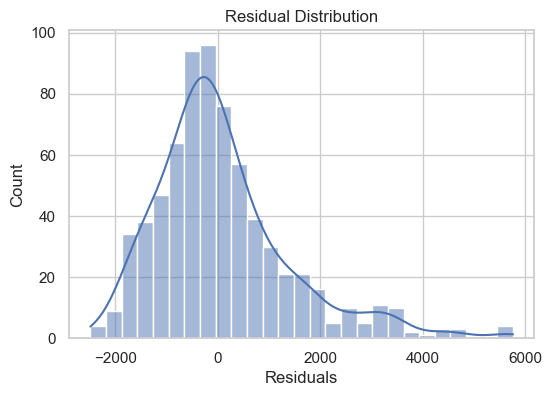

In [19]:
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.show()


**Observation:**  
Residuals should be approximately normally distributed.

### Independence  
Assumed when data is not time-dependent or sequential.  
Here, we assume independence as orders are distinct.


**Part F Summary:**  
Diagnostics indicate whether the model assumptions are reasonable.


# FINAL SECTIONS

## Result (student-written style)
**Result:**  
I successfully performed EDA, built multiple regression models, and evaluated them using MSE, RMSE, and R².  
The multiple regression model performed better than the simple linear model.  
Polynomial regression improved results only when non-linear patterns existed.  
Ridge and Lasso regression controlled overfitting and helped in feature selection.


## Conclusion
**Conclusion:**  
This experiment helped me understand the behavior of different linear regression models.  
I learned how EDA supports model selection, how multiple regression improves accuracy, and how regularization prevents overfitting.  
Model diagnostics confirmed whether assumptions were satisfied.
